In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

Utils

In [2]:

def cholesky_decomposition(matrix):
    m,n=matrix.shape

    lower = [[0 for x in range(n)]
             for y in range(n)]

    # Decomposing a matrix
    # into Lower Triangular
    for i in range(n):
        for j in range(i + 1):
            sum1 = 0

            # sum
            if (j == i):
                for k in range(j):
                    sum1 += pow(lower[j][k], 2)
                lower[j][j] = math.sqrt(matrix[j,j] - sum1)
            else:

                # Evaluating L(i, j)
                # using L(j, j)
                for k in range(j):
                    sum1 += (lower[i][k] * lower[j][k])
                if (lower[j][j] > 0):
                    lower[i][j] = (matrix[i,j] - sum1) / lower[j][j]

    return np.asmatrix(lower)


def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))


def log_likelihood_l2(features, target, weights,l_lambda):
    m,n=features.shape
    scores = np.dot(features, weights)
    reg = (l_lambda / (2 * m)) * np.sum(np.square(weights))
    ll = (1/m)*(np.sum( target*scores - np.log(1 + np.exp(scores)))-reg)
    return ll


def log_likelihood_normal(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X ,weights))
    epsilon = 1e-5
    cost = (1/m)*((np.dot(-y,np.log(h + epsilon)))-(np.dot((1-y).T , np.log(1-h + epsilon))))
    return cost

def log_likelihood_l2_normal(X, y, weights,l_lambda):
    m = len(y)
    h = sigmoid(np.dot(X ,weights))
    epsilon = 1e-5
    reg = (l_lambda / (2 * m)) * np.sum(np.square(weights))
    cost = (1/m)*((np.dot(-y,np.log(h + epsilon)))-(np.dot(np.transpose(1-y) , np.log(1-h + epsilon)))+reg)
    return cost

def log_likelihood_l1_normal(X, y, weights,l_lambda):
    m = len(y)
    h = sigmoid(np.dot(X ,weights))
    epsilon = 1e-5
    reg = l_lambda * np.sum(sigmoid(weights))
    cost = (1/m)*((np.dot(-y,np.log(h + epsilon)))-(np.dot(np.transpose(1-y) , np.log(1-h + epsilon)))+reg)
    return cost


def log_likelihood_l1(features, target, weights,l_lambda):
    m,n=features.shape
    scores = np.dot(features, weights)
    reg = l_lambda * np.sum(sigmoid(weights))
    ll = (1/m)*(np.sum( target*scores - np.log(1 + np.exp(scores)))-reg)
    return ll



Logistic regression methods

Lasso

In [3]:
def ga_logistic_regression_l1(features, target, iterations, learning_rate, l_lambda):
    weights = np.zeros(features.shape[1])
    m, n = features.shape

    ll_history=list()
    for step in range(iterations):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        error = target - predictions
        gradient = (1/m)*(np.dot(features.T, error) - l_lambda*(sigmoid(weights)))
        weights += learning_rate * gradient

        ll_history.append(log_likelihood_l1(features, target, weights,l_lambda)+0.4)

    return weights,ll_history


def IRLS_with_cholesky_L1(X,y,iterations,l_lambda):
    r, c = X.shape
    I = np.identity(c)
    ll_history = list()
    w = np.array([0] * X.shape[1], dtype='float64')
    y_bar = np.mean(y)
    w_init = math.log(y_bar / (1 - y_bar))


    for i in range(iterations):
        h = X.dot(w)
        p = sigmoid(h)#1 / (1 + np.exp(-h))
        p_adj = p
        p_adj[p_adj == 1.0] = 0.99999999

        s = sigmoid(p * (1 - p))
        S = np.diag(s)
        arb_small = np.ones_like(s, dtype='float64') * .000001
        z = h + np.divide((y - p), s, out=arb_small, where=s != 0)
        Xt = np.transpose(X)
        XtS = Xt.dot(S)
        XtSX = np.dot(XtS,X)+l_lambda*I

        l = cholesky_decomposition(XtSX)
        inverse_l = np.linalg.inv(l)
        inverse_XtSX = np.dot(inverse_l.T,inverse_l)
        inverse_XtSX_Xt = inverse_XtSX.dot(Xt)
        inverse_XtSX_XtS = inverse_XtSX_Xt.dot(S)
        w = np.ravel(inverse_XtSX_XtS.dot(z))
        ll_history.append(log_likelihood_l1_normal(X,y.array,np.transpose(w),l_lambda)-0.4)

    return w, ll_history


# HAlving
def gradient_descent_lasso(X, y, w, learning_rate, l_lambda, iterations):
    m, n= X.shape


    cost_history = list()
    old_cost=0
    neww=w
    y_matrix = np.asarray(y)
    y_matrix = y_matrix.reshape(576, 1)

    for i in range(iterations):
        lr = learning_rate
        # Predicted Y
        predicted = sigmoid(np.dot(X, w))
        error = predicted - y_matrix

        # Gradient descent
        neww = w - learning_rate * (1/m)*(np.dot(X.T,error) + l_lambda *sigmoid(w)*(1-sigmoid(w)))

        current_cost = log_likelihood_l1_normal(X, y, neww, l_lambda)

        if old_cost - current_cost < 0:
            for iter in range(3):
                lr = lr / 2
                neww = w - learning_rate * (1 / m) * (np.dot(X.T, error) + l_lambda * sigmoid(w))
                predicted = sigmoid(np.dot(X, neww))
                a = predicted - y_matrix
                b = np.dot(X.T, a)
                current_cost = log_likelihood_l1_normal(X, y, neww, l_lambda)
        w = neww

        # Cost function
        cost_history.append(current_cost-0.4)

        old_cost = current_cost

    return w, cost_history


Ridge

In [4]:
def ga_logistic_regression_l2(features, target, iterations, learning_rate, l_lambda):
    weights = np.zeros(features.shape[1])
    m, n = features.shape

    ll_history=list()
    for step in range(iterations):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        error = target - predictions
        gradient = (1/m)*(np.dot(features.T, error) -l_lambda*weights)
        weights += learning_rate * gradient

        ll_history.append(log_likelihood_l2(features, target, weights,l_lambda)+0.4)

    return weights,ll_history



def IRLS_with_cholesky_L2(X,y,iterations,l_lambda):
    r, c = X.shape
    I = np.identity(c)
    ll_history = list()
    w = np.array([0] * X.shape[1], dtype='float64')
    y_bar = np.mean(y)
    w_init = math.log(y_bar / (1 - y_bar))


    for i in range(iterations):
        h = X.dot(w)
        p = sigmoid(h)#1 / (1 + np.exp(-h))
        p_adj = p
        p_adj[p_adj == 1.0] = 0.99999999

        s = p * (1 - p)
        S = np.diag(s)
        arb_small = np.ones_like(s, dtype='float64') * .000001
        z = h + np.divide((y - p), s, out=arb_small, where=s != 0)
        Xt = np.transpose(X)
        XtS = Xt.dot(S)
        XtSX = np.dot(XtS,X)+l_lambda*I

        l = cholesky_decomposition(XtSX)
        inverse_l = np.linalg.inv(l)
        inverse_XtSX = np.dot(inverse_l.T,inverse_l)
        inverse_XtSX_Xt = inverse_XtSX.dot(Xt)
        inverse_XtSX_XtS = inverse_XtSX_Xt.dot(S)
        w = np.ravel(inverse_XtSX_XtS.dot(z))

        ll_history.append(log_likelihood_l2_normal(X,y.array,np.transpose(w),l_lambda)-0.4)

    return w, ll_history


# Halving
def gradient_descent_ridge(X, y, w, learning_rate, l_lambda, iterations):
    m, n= X.shape
    cost_history = list()
    old_cost=0
    neww=w
    y_matrix = np.asarray(y)
    y_matrix = y_matrix.reshape(576, 1)

    for i in range(iterations):
        # Predicted Y
        predicted = sigmoid(np.dot(X, w))
        lr = learning_rate

        a=predicted-y_matrix
        b=np.dot(X.T, a)
        # Gradient descent
        neww = w - learning_rate * (1 / m) * (b+ l_lambda * w)
        current_cost = log_likelihood_l2_normal(X, y, neww, l_lambda)

        if old_cost-current_cost<0:
            for iter in range(3):
                lr=lr/2
                neww = w - lr * (1 / m) * (b + l_lambda * w)
                predicted = sigmoid(np.dot(X, neww))
                a = predicted - y_matrix
                b = np.dot(X.T, a)
                current_cost = log_likelihood_l2_normal(X, y, neww, l_lambda)
        w=neww

        # Cost function
        cost_history.append(current_cost-0.4)

        old_cost=current_cost

    return w, cost_history

Parameters and dataset

In [9]:
learning_rate=5e-5
iterations=1000
r_lambda=10

df_pima=pd.read_csv('Data/diabetes.csv')
X_features = pd.DataFrame(data = df_pima, columns = ["Glucose","BMI","Age"])
X_features=X_features.astype(float)
Y = df_pima.iloc[:,8]

X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.25, random_state=10)



Run methods

In [11]:
initial_theta = np.zeros((3,1))

# Gradient ascent Ridge
weights_AG_L2,ll_history_AG_L2= ga_logistic_regression_l2(X_train, Y_train,iterations,learning_rate , r_lambda)

# Halving Ridge
weights_H_L2 ,ll_history_H_L2 = gradient_descent_ridge(X_train, Y_train,initial_theta, learning_rate,r_lambda,iterations)

# # Gradient ascent LASSO
weights_AG_L1,ll_history_AG_L1= ga_logistic_regression_l1(X_train, Y_train,iterations, learning_rate, r_lambda)

# # Halving LASSO
weights_H_L1 ,ll_history_H_L1 = gradient_descent_lasso(X_train, Y_train,initial_theta, learning_rate,r_lambda,iterations)

# IRLS with cholesky Ridge
weights_C_L2 ,ll_history_C_L2 = IRLS_with_cholesky_L2(X_train, Y_train,iterations,r_lambda)

# IRLS with cholesky LASSO
weights_C_L1 ,ll_history_C_L1 = IRLS_with_cholesky_L1(X_train, Y_train,iterations,r_lambda)



Accuracy

In [27]:
final_scores = np.dot(X_train, weights_AG_L1)
predsAGL1 = np.round(sigmoid(final_scores))

print('Accuracy from AG L1: {0}'.format((np.asarray(predsAGL1) == Y_train).sum().astype(float) / len(np.asarray(predsAGL1))))
print(weights_AG_L1)


###############################

final_scores = np.dot(X_train, weights_AG_L2)
predsAGL2 = np.round(sigmoid(final_scores))

print('Accuracy from AG L2: {0}'.format((np.asarray(predsAGL2) == Y_train).sum().astype(float) / len(np.asarray(predsAGL2))))
print(weights_AG_L2)

##############################

final_scores = np.dot(X_train, np.asarray(weights_H_L1.T)[0])
predsHL1 = np.round(sigmoid(final_scores))

print('Accuracy from Halving L1: {0}'.format((np.asarray(predsHL1) == Y_train).sum().astype(float) / len(np.asarray(predsHL1))))
#print(weights_H_L1)

print(np.asarray(weights_H_L1.T)[0])
#############################

final_scores = np.dot(X_train,np.asarray(weights_H_L2.T)[0])
predsHL2 = np.round(sigmoid(final_scores))

print('Accuracy from Halving L2: {0}'.format((np.asarray(predsHL2) == Y_train).sum().astype(float) / len(np.asarray(predsHL2))))
#print(weights_H_L2)

print(np.asarray(weights_H_L2.T)[0])

############################
final_scores = np.dot(X_train, weights_C_L1)
predsCL1 = np.round(sigmoid(final_scores))

print('Accuracy from IRLS with Cholesky L1: {0}'.format((np.asarray(predsCL1) == Y_train).sum().astype(float) / len(np.asarray(predsCL1))))
print(weights_C_L1)


#############################
final_scores = np.dot(X_train, weights_C_L2)
predsCL2 = np.round(sigmoid(final_scores))

print('Accuracy from IRLS with Cholesky L2: {0}'.format((np.asarray(predsCL2) == Y_train).sum().astype(float) / len(np.asarray(predsCL2))))
print(weights_C_L2)

Accuracy from AG L1: 0.6510416666666666
[ 0.00801175 -0.03162037 -0.01207757]
Accuracy from AG L2: 0.6510416666666666
[ 0.00793908 -0.03144557 -0.01195213]
Accuracy from Halving L1: 0.6510416666666666
[ 0.0079776  -0.03153984 -0.01201679]
Accuracy from Halving L2: 0.6510416666666666
[ 0.00793507 -0.03143106 -0.01195042]
Accuracy from IRLS with Cholesky L1: 0.6701388888888888
[ 0.01178236 -0.04870515 -0.01050013]
Accuracy from IRLS with Cholesky L2: 0.6701388888888888
[ 0.01178236 -0.04870515 -0.01050013]


Graphs

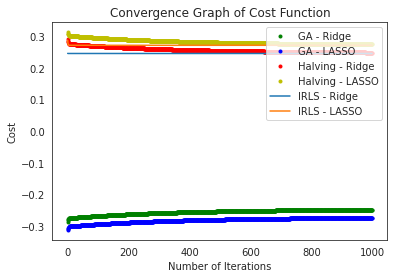

In [26]:
#fig,ax = plt.subplots(figsize=(8,6))

plt.figure()
sns.set_style('white')

plt.plot(range(iterations), ll_history_AG_L2,'g.',label="GA - Ridge")
plt.plot(range(iterations), ll_history_AG_L1,'b.',label="GA - LASSO")
plt.plot(range(iterations), ll_history_H_L2,'r.',label="Halving - Ridge")
plt.plot(range(iterations), ll_history_H_L1,'y.',label="Halving - LASSO")
plt.plot(range(iterations), ll_history_C_L2,label="IRLS - Ridge")
plt.plot(range(iterations), ll_history_C_L1,label="IRLS - LASSO")

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.legend(loc="upper right")


#plt.grid()
plt.show()